# Modeling - Pooled OLS, Fixed Effects, Random Effects

In [44]:
#imports
from linearmodels import PooledOLS
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import numpy.linalg as la
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

Special credit to Bernhard Brugger, whose insightful article provided a comprehensive step by step approach to panel data regression in Python. You can view article here https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8.


In [45]:
#Reading data
df = pd.read_csv ('../data/cleaned_energy_data.csv')

In [46]:
#Creating new columns for dummy variables for sub categories 

landlocked = ['Afghanistan', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Bhutan',
              'Bolivia', 'Botswana', 'Burkina Faso', 'Burundi', 'Central African Republic', 'Chad',
              'Czech Republic','Eswatini', 'Ethiopia', 'Hungary', 'Kazakhstan', 'Kyrgyzstan', 'Laos',
              'Lesotho', 'Liechtenstein','Luxembourg', 'Malawi', 'Mali', 'Moldova', 'Mongolia',
              'Nepal', 'Niger', 'North Macedonia', 'Paraguay','Rwanda', 'San Marino', 'Serbia',
              'Slovakia', 'South Sudan', 'Switzerland', 'Tajikistan','Turkmenistan', 'Uganda',
              'Uzbekistan', 'Vatican City', 'Zambia', 'Zimbabwe']

nuclear = ['Argentina', 'Armenia', 'Belarus', 'Belgium', 'Brazil', 'Bulgaria', 'Canada', 'China',
           'Czech Republic', 'Finland', 'France', 'Germany', 'Hungary', 'India', 'Iran', 'Japan',
           'Kazakhstan', 'Lithuania', 'Mexico', 'Netherlands', 'Pakistan', 'Romania', 'Russia',
           'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
           'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States']

least_developed = ['Afghanistan', 'Angola', 'Bangladesh', 'Benin', 'Bhutan', 'Burkina Faso',
                   'Burundi', 'Cambodia', 'Central African Republic', 'Chad', 'Comoros',
                   'Congo-Brazzaville', 'Congo-Kinshasa', 'Djibouti', 'Ethiopia', 'Gambia, The',
                   'Guinea', 'Guinea-Bissau', 'Haiti', 'Kiribati', 'Laos',  'Lesotho', 'Liberia',
                   'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar', 'Nepal',
                   'Niger', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone',
                   'Solomon Islands', 'Somalia', 'Sudan', 'Togo', 'Uganda', 'Tanzania', 'Yemen',
                   'Zambia']

oil_exporters = ['Algeria', 'Angola', 'Congo-Brazzaville', 'Equatorial Guinea', 'Gabon', 'Iran',
                 'Iraq', 'Kuwait', 'Libya', 'Nigeria', 'Saudi Arabia', 'United Arab Emirates',
                 'Venezuela', 'United States', 'Russia', 'China']

opec = ['Algeria', 'Angola', 'Congo-Brazzaville', 'Equatorial Guinea', 'Gabon', 'Iran', 'Iraq',
        'Kuwait', 'Libya', 'Nigeria', 'Saudi Arabia', 'United Arab Emirates','Venezuela']

df['is_landlocked'] = df['country'].map(lambda x: 1 if x in landlocked else 0)
df['is_nuclear'] = df['country'].map(lambda x: 1 if x in nuclear else 0)
df['is_least_developed'] = df['country'].map(lambda x: 1 if x in least_developed else 0)
df['is_oil_exporter'] = df['country'].map(lambda x: 1 if x in oil_exporters else 0)
df['is_opec'] = df['country'].map(lambda x: 1 if x in opec else 0)

In [47]:
#displaying first 5 rows and dimensions of dataframe
display(df.head())
display(df.shape)

,country,year,population,life_expectancy,consumption_per_capita,consumption_per_GDP,ppp_2015USD,production_total,production_coal,production_natural_gas,...,exports_electricity,emissions_co2_emissions,emissions_coal_and_coke,emissions_consumed_natural_gas,emissions_petroleum_and_other_liquids,is_landlocked,is_nuclear,is_least_developed,is_oil_exporter,is_opec
0,World,1992,5.481774e+06,65.769659,64.426755,6.923158,51013.270526,353.718416,92.558725,76.984223,...,400.795117,22529.424264,8587.186368,4076.853622,9865.384274,0,0,0,0,0
1,Afghanistan,1992,1.448550e+04,51.641000,2.159523,1.042253,30.013600,0.016143,0.000158,0.011092,...,0.000000,1.704078,0.015551,0.588528,1.100000,1,0,1,0,0
2,Albania,1992,3.245890e+03,71.802000,25.937798,8.087302,10.410300,0.065519,0.003415,0.003760,...,0.560000,3.901890,0.502372,0.199519,3.200000,0,0,0,0,0
3,Algeria,1992,2.702830e+04,67.575000,48.164981,5.592648,232.773000,5.031036,0.000380,2.325281,...,1.061000,74.390488,2.687475,45.703013,26.000000,0,0,0,1,1
4,Angola,1992,1.265740e+04,45.230000,6.689229,1.423070,59.496900,1.152349,0.000000,0.021076,...,0.000000,5.218203,0.000000,1.118203,4.100000,0,0,1,1,1


(4724, 38)

In [48]:
#Setting multilevel index
df= df.set_index(['country','year'])
df.head()

,,population,life_expectancy,consumption_per_capita,consumption_per_GDP,ppp_2015USD,production_total,production_coal,production_natural_gas,production_petrolium_and_other_liquids,production_nuclear,...,exports_electricity,emissions_co2_emissions,emissions_coal_and_coke,emissions_consumed_natural_gas,emissions_petroleum_and_other_liquids,is_landlocked,is_nuclear,is_least_developed,is_oil_exporter,is_opec
country,year,,,,,,,,,,,,,,,,,,,,,
World,1992,5.481774e+06,65.769659,64.426755,6.923158,51013.270526,353.718416,92.558725,76.984223,135.972335,21.27974,...,400.795117,22529.424264,8587.186368,4076.853622,9865.384274,0,0,0,0,0
Afghanistan,1992,1.448550e+04,51.641000,2.159523,1.042253,30.013600,0.016143,0.000158,0.011092,0.000000,NaN,...,0.000000,1.704078,0.015551,0.588528,1.100000,1,0,1,0,0
Albania,1992,3.245890e+03,71.802000,25.937798,8.087302,10.410300,0.065519,0.003415,0.003760,0.025384,NaN,...,0.560000,3.901890,0.502372,0.199519,3.200000,0,0,0,0,0
Algeria,1992,2.702830e+04,67.575000,48.164981,5.592648,232.773000,5.031036,0.000380,2.325281,2.703338,NaN,...,1.061000,74.390488,2.687475,45.703013,26.000000,0,0,0,1,1
Angola,1992,1.265740e+04,45.230000,6.689229,1.423070,59.496900,1.152349,0.000000,0.021076,1.122669,NaN,...,0.000000,5.218203,0.000000,1.118203,4.100000,0,0,1,1,1


In [49]:
#dropping "World" rows
df.drop('World',level=0, axis= 0, inplace=True)

In [50]:
#viewing first 5 rows and dimensions of dataframe
display(df.head())
display (df.shape)


,,population,life_expectancy,consumption_per_capita,consumption_per_GDP,ppp_2015USD,production_total,production_coal,production_natural_gas,production_petrolium_and_other_liquids,production_nuclear,...,exports_electricity,emissions_co2_emissions,emissions_coal_and_coke,emissions_consumed_natural_gas,emissions_petroleum_and_other_liquids,is_landlocked,is_nuclear,is_least_developed,is_oil_exporter,is_opec
country,year,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1992,14485.5000,51.641,2.159523,1.042253,30.01360,0.016143,0.000158,0.011092,0.000000,NaN,...,0.000,1.704078,0.015551,0.588528,1.1,1,0,1,0,0
Albania,1992,3245.8900,71.802,25.937798,8.087302,10.41030,0.065519,0.003415,0.003760,0.025384,NaN,...,0.560,3.901890,0.502372,0.199519,3.2,0,0,0,0,0
Algeria,1992,27028.3000,67.575,48.164981,5.592648,232.77300,5.031036,0.000380,2.325281,2.703338,NaN,...,1.061,74.390488,2.687475,45.703013,26.0,0,0,0,1,1
Angola,1992,12657.4000,45.230,6.689229,1.423070,59.49690,1.152349,0.000000,0.021076,1.122669,NaN,...,0.000,5.218203,0.000000,1.118203,4.1,0,0,1,1,1
Antigua and Barbuda,1992,64.9886,72.006,91.763340,5.867116,1.01644,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000,0.400000,0.000000,0.000000,0.4,0,0,0,0,0


(4697, 36)

In [66]:
#preprocessing years column
years = df.index.get_level_values('year').to_list()
df['year'] = pd.Categorical(years)

To estimate a Pooled OLS regression, the following 5 assumptions have to be met:
- Linearity
- Exogeneity
- Homoskedasticity
- No autocorrelation
- Independent Variables are not stochastic
- No multicollinearity.

If the assumptions of No homoskedasticity and No autocorrelation, in particular are unmet, this implies that a fixed effects/random effects model will be more appropriate. Hence, we checked for these two assumptions, as follows:

In [52]:
#defined exogenous variables with constant
exog = sm.tools.tools.add_constant(df[['emissions_co2_emissions', 'emissions_coal_and_coke',
                                       'emissions_consumed_natural_gas','consumption_per_capita', ]])

#defined endogenous (target) variable
endog = df['life_expectancy']

#instantiated pooled OLS model
model = PooledOLS (endog, exog)

#fitting model
pooledOLS_res = model.fit(cov_type='clustered', cluster_entity=True)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids


<Figure size 720x720 with 0 Axes>

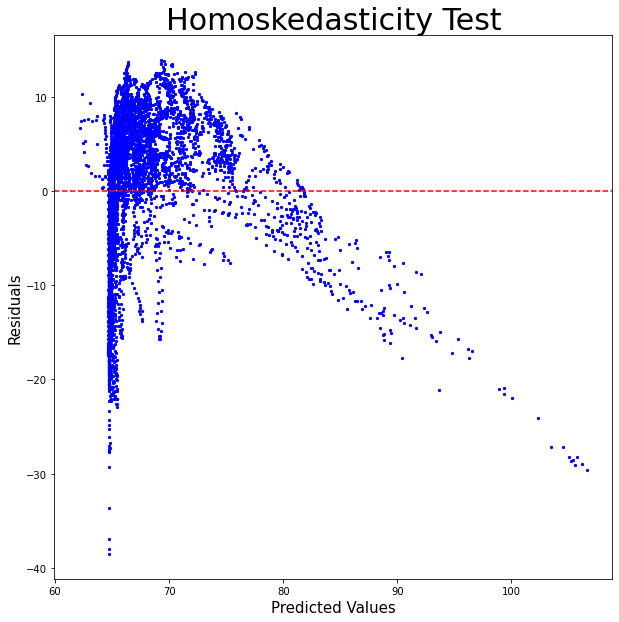

In [53]:
#plot to check for homoskedasticity
fig = plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue', s= 5)
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.savefig('Homoskedasticity Test')
plt.show();

The above plot suggests the presence of heteroskedasticity.

In [54]:
#Checking for Heteroskedasticity with statistical tests:

#A) White Test
pooled_OLS_dataset = pd.concat([df, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(df[['emissions_co2_emissions','emissions_consumed_natural_gas',
                                      'consumption_per_capita','emissions_coal_and_coke']]).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

#B) Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

#credit: https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8

{'LM-Stat': 908.9486719520442, 'LM p-val': 5.2213917198208466e-185, 'F-Stat': 80.24664386463432, 'F p-val': 2.6762070678457837e-206}
{'LM-Stat': 31.45490444430332, 'LM p-val': 2.47220274109327e-06, 'F-Stat': 7.908315568166851, 'F p-val': 2.3821616955203534e-06}


P value < 0.05 suggests that there is heteroskedasticity in the model, hence "no homoskedascity" assumption has been violated.

In [55]:
#Checking for Autocorrelation

#Durbin Watson Test

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

1.7827157345276308


There is positive autocorrelation in the model because the durbin watson statistic < 2. The assumptions of homoskedasticy and no autocorrelation have been violated. As such, we have to utilze a fixed effects or random effects model.

We defined the following null and alternative hypothesis:

- H0: Energy consumption has no effect on life expectancy
- H1: Energy consumption has an effect on life expectancy.


In [56]:
#Estimating Fixed Effects and Random Effects Models

exog = sm.tools.tools.add_constant(df[['emissions_co2_emissions','emissions_coal_and_coke',
                                       'emissions_petroleum_and_other_liquids', 'consumption_per_capita']])
endog = df['life_expectancy']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 

# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
#print results
print(re_res)
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:        life_expectancy   R-squared:                        0.0803
Estimator:              RandomEffects   R-squared (Between):              0.1422
No. Observations:                4697   R-squared (Within):               0.0490
Date:                Fri, Dec 03 2021   R-squared (Overall):              0.1370
Time:                        17:46:38   Log-likelihood                -1.199e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      102.43
Entities:                         178   P-value                           0.0000
Avg Obs:                       26.388   Distribution:                  F(4,4692)
Min Obs:                       0.0000                                           
Max Obs:                       27.000   F-statistic (robust):             66.525
                            

In [57]:
# function to perform Hausman Test to indicate preferred model
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    
    

    df= b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval
#credit: https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8

In [58]:
#printing results
hausman_results = hausman(fe_res, re_res) 
print('chi-Squared:' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

#credit: https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8

chi-Squared:52.156401754700994
degrees of freedom: 5
p-Value: 5.010652111932133e-10


Because the p value is < 0.05, we reject the null hypothesis that the preferred model is random effects. In this case,the fixed effects model is more suitable. 

The fixed effects model coefficients show that ceteris paribus,:

- For every one million ton increase in Co2 emissions, we expect life expectancy to increase by about 1 week;
- For every one million ton increase in Co2 emissions from coal/coke, we expect life expectancy to decline by about 1 week ;
- For every one million ton increase in Co2 emissions from petrol & other liquids, we expect life expectancy to decline by about 3 days ; and
- For every million British Thermal Units (BTU) of energy consumed per person, we expect life expectancy to increase by about 3 days. 


## Oil Exporting Countries

In [59]:
#Filtering subset of data
oil_exporters = df[df['is_oil_exporter']==1]
oil_exporters.shape

(432, 37)

In [60]:
#Estimating Fixed Effects and Random Effects Model

exog_oil = sm.tools.tools.add_constant(oil_exporters[['emissions_co2_emissions','emissions_coal_and_coke',
                                       'emissions_petroleum_and_other_liquids', 'consumption_per_capita']])
endog_oil = oil_exporters['life_expectancy']

# random effects model
model_re_oil = RandomEffects(endog_oil, exog_oil) 
re_res_oil = model_re_oil.fit() 

# fixed effects model
model_fe_oil = PanelOLS(endog_oil, exog_oil, entity_effects = True) 
fe_res_oil = model_fe_oil.fit() 

#print results
print(re_res_oil)
print(fe_res_oil)

                        RandomEffects Estimation Summary                        
Dep. Variable:        life_expectancy   R-squared:                        0.1817
Estimator:              RandomEffects   R-squared (Between):              0.1398
No. Observations:                 432   R-squared (Within):               0.1834
Date:                Fri, Dec 03 2021   R-squared (Overall):              0.1433
Time:                        17:46:40   Log-likelihood                   -995.03
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      23.696
Entities:                         173   P-value                           0.0000
Avg Obs:                       2.4971   Distribution:                   F(4,427)
Min Obs:                       0.0000                                           
Max Obs:                       27.000   F-statistic (robust):             23.696
                            

In [61]:
#printing results
hausman_results_oil = hausman(fe_res_oil, re_res_oil) 
print('chi-Squared:' + str(hausman_results_oil[0]))
print('degrees of freedom: ' + str(hausman_results_oil[1]))
print('p-Value: ' + str(hausman_results_oil[2]))

chi-Squared:12.580515098293887
degrees of freedom: 5
p-Value: 0.027643502813343802


Because the p value is < 0.05, we reject the null hypothesis that the preferred model is random effects. In this case,the fixed effects model is more suitable. 


The fixed effects model coefficients show that ceteris paribus, in oil exporting countries:

- For every one million ton increase in Co2 emissions, we expect life expectancy to increase by about 4 days;
- For every one million ton increase in Co2 emissions from coal/coke, we expect life expectancy to decline by about 4 days ;
- For every one million ton increase in Co2 emissions from petrol & other liquids, we expect life expectancy to decline by about 2 days ; and
- For every million British Thermal Units (BTU) of energy consumed per person, we expect life expectancy to increase by some hours. 


## LDCs

In [62]:
#filtering subset of data
ldc = df[df['is_least_developed']==1]
ldc.shape

(1134, 37)

In [63]:
#Fixed Effects and Random Effects Model

exog_ldc = sm.tools.tools.add_constant(ldc[['emissions_co2_emissions','emissions_coal_and_coke', 'consumption_per_capita', "emissions_petroleum_and_other_liquids"]])
endog_ldc = ldc['life_expectancy']

# random effects model
model_re_ldc = RandomEffects(endog_ldc, exog_ldc) 
re_res_ldc = model_re_ldc.fit() 

# fixed effects model
model_fe_ldc = PanelOLS(endog_ldc, exog_ldc, entity_effects = True) 
fe_res_ldc = model_fe_ldc.fit() 

#print results
print(re_res_ldc)
print(fe_res_ldc)

                        RandomEffects Estimation Summary                        
Dep. Variable:        life_expectancy   R-squared:                        0.2406
Estimator:              RandomEffects   R-squared (Between):              0.0474
No. Observations:                1134   R-squared (Within):               0.2473
Date:                Fri, Dec 03 2021   R-squared (Overall):              0.1320
Time:                        17:46:42   Log-likelihood                   -3241.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      89.424
Entities:                         177   P-value                           0.0000
Avg Obs:                       6.4068   Distribution:                  F(4,1129)
Min Obs:                       0.0000                                           
Max Obs:                       27.000   F-statistic (robust):             89.424
                            

In [64]:
#printing results 
hausman_results_ldc = hausman(fe_res_ldc, re_res_ldc) 
print('chi-Squared:' + str(hausman_results_ldc[0]))
print('degrees of freedom: ' + str(hausman_results_ldc[1]))
print('p-Value: ' + str(hausman_results_ldc[2]))

chi-Squared:8.2046063200278
degrees of freedom: 5
p-Value: 0.14531404436440357


Because the p value is > 0.05, we fail to reject the null hypothesis that the preferred model is random effects. Thus, the random effects model is more suitable in this case.


The random effects model coefficients show that ceteris paribus, in least developed countries:

- For every one million ton increase in Co2 emissions, we expect life expectancy to decline by about 4 days;
- For every one million ton increase in Co2 emissions from coal/coke, we expect life expectancy to increase by about 2 weeks ;
- For every one million ton increase in Co2 emissions from petrol & other liquids, we expect life expectancy to increase by about 1 month ; and
- For every million British Thermal Units (BTU) of energy consumed per person, we expect life expectancy to increase by about 3 days. 


# Conclusion

- Yes, energy consumption does affect life expectancy. However there are nuances, with regards to pollutant, and country's level of development.
- We explored the relationship between energy consumption and life expectancy for 172 countries from 1992-2018, using fixed effects and random effects models. 
- Emissions from petroleum, coal and coke were found to have a significant, negative effect on life expectancy, while C02 emissions showed a significant positive relationship with life expectancy. However, this did not hold in the specific case of Least Developed Countries (LDCs).
- CO2 emissions showed a significant, negative relationship with life expectancy in LDCs, whereas emissions from coal,coke and petroleum showed a significant, positive relationship. 
- Energy consumption per capita showed a significant positive effect on life expectancy, worldwide, as well as in the two subsets analyzed.

# Recommendations

- We recommend that there is need to study this relationship on more micro levels, for instance, using more granular data, including more features which explain life expectancy, longer time span to better understand impacts of energy consumption/efficiency on life expectancy.
- There is need for more research into use of coal/coke and petroleum in LDCs. How can we get these countries to move towards cleaner forms of energy? This is especially important given that the goal of sustainable development is a collective one.
